<a href="https://colab.research.google.com/github/showman-sharma/Biological_Learning/blob/master/BioHashing_SImilaritySearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Bio-Inspired Hashing for Unsupervised Similarity Search](https://www.ibm.com/blogs/research/2020/07/bio-inspired-hashing-unsupervised-similarity-search/)

We look into the working of BioHashing, a novel similarity search algorithm


In [ ]:
from keras.datasets import mnist
from scipy.spatial import distance
import numpy as np
import matplotlib.pyplot as plt
import random

In [ ]:
(mat, train_y), (test_X, test_y) = mnist.load_data()
Nc=10
N=784
N_total = 60000
Ns=6000

In [ ]:
M=np.zeros((0,N))
M_labels = train_y[:Ns]
for i in range(Ns):
    M=np.concatenate((M, mat[i].reshape(1,N)), axis=0)
M=M/255.0

To draw a heatmap of the weights a helper function is created:

In [ ]:
def draw_weights(synapses, Kx, Ky):
    yy=0
    HM=np.zeros((28*Ky,28*Kx))
    for y in range(Ky):
        for x in range(Kx):
            HM[y*28:(y+1)*28,x*28:(x+1)*28]=synapses[yy,:].reshape(28,28)
            yy += 1
    plt.clf()
    nc=np.amax(np.absolute(HM))
    im=plt.imshow(HM,cmap='bwr',vmin=-nc/7,vmax=nc/7)
    fig.colorbar(im,ticks=[np.amin(HM), 0, np.amax(HM)])
    plt.axis('off')
    fig.canvas.draw()

This cell defines paramaters of the algorithm: eps0 - initial learning rate that is linearly annealed during training; hid - number of hidden units that are displayed as an Ky by Kx array by the helper function defined above; mu - the mean of the gaussian distribution that initializes the weights; sigma - the standard deviation of that gaussian; Nep - number of epochs; Num - size of the minibatch; prec - parameter that controls numerical precision of the weight updates; delta - the strength of the anti-hebbian learning; p - Lebesgue norm of the weights; k - ranking parameter.

In [ ]:
eps0=2e-2    # learning rate
Kx=100
Ky=10
hid=Kx*Ky    # number of hidden units that are displayed in Ky by Kx array
mu=0.0
sigma=1.0
Nep=200      # number of epochs
Num=100      # size of the minibatch
prec=1e-30
delta=0.4    # Strength of the anti-hebbian learning
p=2.0        # Lebesgue norm of the weights
k=2          # ranking parameter, must be integer that is bigger or equal than 2
a = 0.4      # activity, between 0 and 1

## Training the weights
This cell defines the main code. The external loop runs over epochs nep, the internal loop runs over minibatches. For every minibatch the overlap with the data tot_input is calculated for each data point and each hidden unit. The sorted strengths of the activations are stored in y. The variable yl stores the activations of the post synaptic cells - it is denoted by g(Q) in Eq 3 of Unsupervised Learning by Competing Hidden Units, see also Eq 9 and Eq 10. The variable ds is the right hand side of Eq 3. The weights are updated after each minibatch in a way so that the largest update is equal to the learning rate eps at that epoch. The weights are displayed by the helper function after each epoch

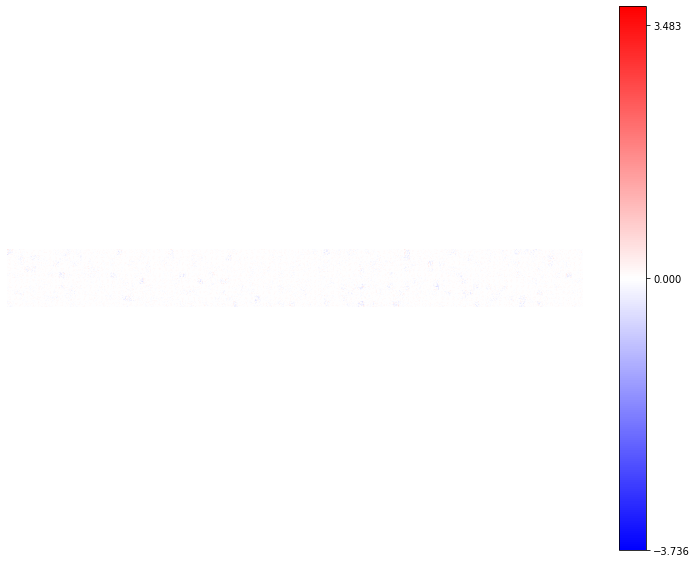

In [ ]:
fig=plt.figure(figsize=(12.9,10))

synapses = np.random.normal(mu, sigma, (hid, N))
for nep in range(Nep):
    eps=eps0*(1-nep/Nep)
    M=M[np.random.permutation(Ns),:]
    for i in range(Ns//Num):
        inputs=np.transpose(M[i*Num:(i+1)*Num,:])
        sig=np.sign(synapses)
        tot_input=np.dot(sig*np.absolute(synapses)**(p-1),inputs)
        
        y=np.argsort(tot_input,axis=0)
        yl=np.zeros((hid,Num))
        yl[y[hid-1,:],np.arange(Num)]=1.0
        yl[y[hid-k],np.arange(Num)]=-delta
        
        xx=np.sum(np.multiply(yl,tot_input),1)
        ds=np.dot(yl,np.transpose(inputs)) - np.multiply(np.tile(xx.reshape(xx.shape[0],1),(1,N)),synapses)
        
        nc=np.amax(np.absolute(ds))
        if nc<prec:
            nc=prec
        synapses += eps*np.true_divide(ds,nc)
        
    draw_weights(synapses, Kx, Ky)

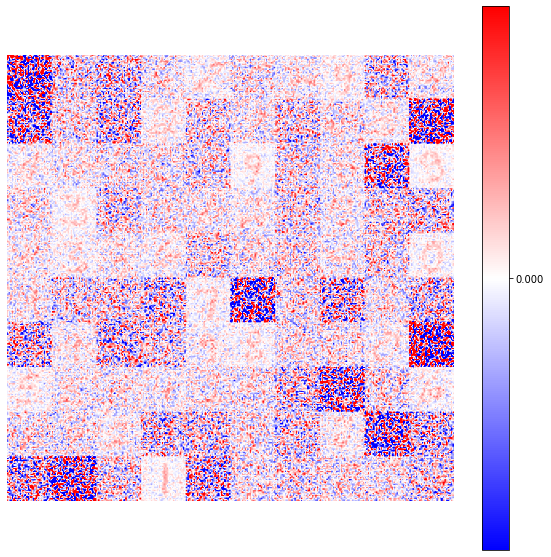

In [ ]:
fig=plt.figure(figsize=(10,10))
draw_weights(synapses,10,10)

## Similarity search
We use the above weights to create a hashcode and by finding the top inputs in the memeory which have least hamming distance with the searched item in the hash domain, we get the results for similarity

In [ ]:
def hashing(synapses, inputs,k):
  Num = inputs.shape[0]
  N = inputs.shape[1]
  hid = synapses.shape[0]
  hashcodes = np.zeros((0,hid))
  h = np.dot(synapses,np.transpose(inputs))
  y=np.argsort(h,axis=0)
  y1=np.full((hid,Num),-1)
  y1[y[hid-k:hid,:],np.arange(Num)]=1.0
  return np.transpose(y1)


In [ ]:
def similaritySearch(synapses, search,R, stack = M,stack_label= M_labels,a=a):
  hid = synapses.shape[0]
  Num = stack.shape[0]
  stack_hash = hashing(synapses,stack,int(a*hid))
  search_hash = hashing(synapses,search,int(a*hid))[0]
  distances = np.zeros((0,1))
  for i in range(Num):
    given_hash = stack_hash[i,:]
    distances=np.append(distances,distance.hamming(search_hash,given_hash))
  dist_sort = np.argsort(distances)
  return stack[dist_sort[:R],:],stack_label[dist_sort[:R]]


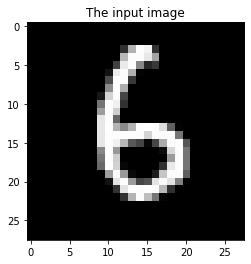

In [ ]:
input = test_X[21].reshape(1,N)
input_image = input.reshape((28,28))
plt.imshow(input_image, cmap='gray')
plt.title('The input image')
plt.show()


In [ ]:
similars,sim_labels = similaritySearch(synapses,input,9)

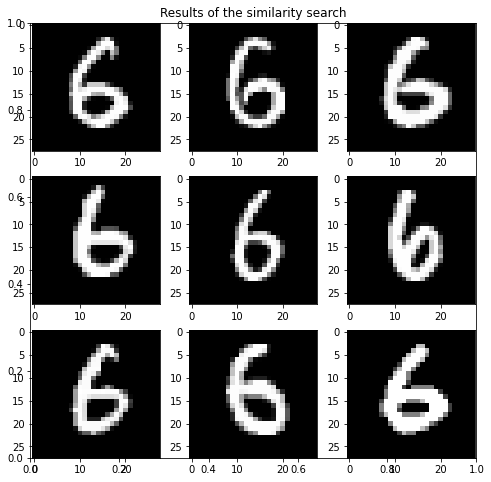

In [ ]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
plt.title('Results of the similarity search')
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    img = similars[i-1].reshape((28,28))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
    
plt.show()

# Testing efficiency
We give 50 search inputs, along with their labels to the similarity search. For each of these inputs, we check the fraction of results with label same as search label. Thus we calculate efficiency by averaging this faction over gthe 100 inputs.

In [ ]:
M=np.zeros((0,N))
M_labels = train_y[:Ns]
for i in range(Ns):
    M=np.concatenate((M, mat[i].reshape(1,N)), axis=0)
M=M/255.0

In [ ]:
def avg_rights(synapses, searches,search_labels,R, stack = M,stack_label= M_labels,a=a):
  l = searches.shape[0]
  #print(l)
  avg = 0
  for i in range(search_labels.shape[0]):
    search = searches[i].reshape(1,synapses.shape[1])
    search_label = search_labels[i]
    sims,sim_labels = similaritySearch(synapses, search,R, stack,stack_label,a)
    rights = 0 
    for i in range(R):
      if sim_labels[i] == search_label:
        rights+=1/R
    #print(search_label,sim_labels)    
    avg += rights/l
  return avg    

In [ ]:
eff = avg_rights(synapses,test_X[:150],test_y[:150],9)

In [ ]:
print('efficiency = ',eff*100,'%')

efficiency =  90.88888888888893 %
